In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
class Vitrage():
    def __init__(self, image, numcolors = 3, black_threshold=10):
        image = np.array(Image.open(image)) # Load the image pixels into an array
        self.black_threshold = black_threshold
        self.shape = image.shape # remember the original shape
        self.pixels = image.reshape(self.shape[0] * self.shape[1], 3) # Flatten the image into a 1x3 matrix of size <pixel_count> by 3 (R, G and B channels)
        self.colors = np.ndarray((numcolors+1, 3), dtype=int)
        self.pick_random_colors()
        
    def pick_random_colors(self):
        self.colors[0] = [0,0,0]
        
        i = 1
        while i < self.colors.shape[0]:
            # pick a random pixel for a base color, check if not too dark
            # TODO: Watch out for duplicates
            self.colors[i] = self.pixels[np.random.randint(0, self.pixels.shape[0])]
            if self.colors[i][0] < self.black_threshold and self.colors[i][1] < self.black_threshold and self.colors[i][2] < self.black_threshold:
                # too dark, pick a different color
                continue
            i+=1
        
        return self.colors
    
    def optimize(self, epochs=1):
        for i in range(epochs):
            print(f"Epoch {i+1}/{epochs}")
            assoc = np.ndarray((self.pixels.shape[0], 1), dtype=int)
            
            # Classify the pixels to current centroids
            print("Classifying pixels...")
            for j, p in enumerate(self.pixels):
                if p[0] < self.black_threshold and p[1] < self.black_threshold and p[2] < self.black_threshold:
                    assoc[j] = 0
                    continue
                
                class_distance = [0 for k in range(self.colors.shape[0] - 1)]
                for k in range(self.colors.shape[0] - 1):
                    class_distance[k] = abs(self.colors[k+1][0] - p[0]) + abs(self.colors[k+1][1] - p[1]) + abs(self.colors[k+1][2] - p[2])
                    
                assoc[j] = class_distance.index(min(class_distance)) + 1
                
            print("Getting new centroid values...")
            # Get new centroid values
            centroid_counts = [0 for n in range((self.colors.shape[0] - 1))]
            centroid_sums = [[0, 0, 0] for n in range((self.colors.shape[0] - 1))]
            for j, a in enumerate(assoc):
                centroid_counts[a[0]-1] += 1
                centroid_sums[a[0]-1] += self.pixels[j]
                
            for j in range(self.colors.shape[0] - 1):
                if centroid_counts[j] > 0:
                    self.colors[j+1] = centroid_sums[j] // centroid_counts[j]
        
        print("Optimization complete!")
                
    def get_image(self):
        im = np.copy(self.pixels)
        
        for i in range(len(im)):
            im[i] = self.get_replacement_color(im[i])
            
        return im.reshape(self.shape[0], self.shape[1], 3)
            
    def get_replacement_color(self, p):
        if p[0] < self.black_threshold and p[1] < self.black_threshold and p[2] < self.black_threshold:
            return self.colors[0]

        class_distance = [9999999 for k in range(self.colors.shape[0] - 1)]
        for k in range(self.colors.shape[0] - 1):
            class_distance[k] = abs(self.colors[k+1][0] - p[0]) + abs(self.colors[k+1][1] - p[1]) + abs(self.colors[k+1][2] - p[2])

        c = class_distance.index(min(class_distance)) + 1
        
        return self.colors[c]
    
    def save(self, file_name = "out.jpeg"):
        Image.fromarray(self.get_image()).save(file_name)
        print("Image Saved!")

In [3]:
v = Vitrage('goran.jpeg', black_threshold=100, numcolors=5)
v.optimize(10)
v.save()

Epoch 1/10
Classifying pixels...
Getting new centroid values...
Epoch 2/10
Classifying pixels...
Getting new centroid values...
Epoch 3/10
Classifying pixels...
Getting new centroid values...
Epoch 4/10
Classifying pixels...
Getting new centroid values...
Epoch 5/10
Classifying pixels...
Getting new centroid values...
Epoch 6/10
Classifying pixels...
Getting new centroid values...
Epoch 7/10
Classifying pixels...
Getting new centroid values...
Epoch 8/10
Classifying pixels...
Getting new centroid values...
Epoch 9/10
Classifying pixels...
Getting new centroid values...
Epoch 10/10
Classifying pixels...
Getting new centroid values...
Optimization complete!
Image Saved!


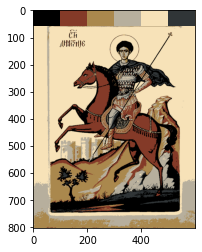

In [4]:
# Show the generated color pallette

im = np.array(Image.fromarray(v.get_image()), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

w = im.shape[1] / v.colors.shape[0]

for i, color in enumerate(v.colors):
    # Create a Rectangle patch
    rect = patches.Rectangle((i*w, 0),w, 58,facecolor=color/255.)

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()